<div style="text-align: right"> &uarr;   Ensure Kernel is set to  &uarr;  </div><br><div style="text-align: right"> conda_amazonei_tensorflow2_p36  </div>

# Tensorflow Estimator Bring your own Model

In this notebook we will go through and run a tensorflow model to classify the junctions as priority, signal and roundabout as seen in data prep.

The outline of this notebook is 

1. To prepare a training script (provided).

2. Use the AWS provided Tensorflow container and provide our script to it.

3. Run training.

4. Deploy model to end point.

5. Test using an image in couple of possible ways 

Upgrade Sagemaker so we can access the latest containers

In [10]:
!pip install -U 'sagemaker>=2.48'

Let us also upgrade out version of Tensorflow to v2.4.1

In [11]:
!pip install tensorflow==2.4.1

Lets make sure that our environment is using Tensorflow 2.4.1 otherwise we will need to restart the notebook kernel

In [12]:
import tensorflow as tf

print(f"Tensorflow version {tf.__version__}")

if tf.__version__ != "2.4.1":
    print("This notebook kernel needs to be restarted!!!!")
    exit()

Tensorflow version 2.4.1


Lets start by importing some libraries that we will be using later

In [13]:
import os
import sagemaker
import numpy as np
from sagemaker.tensorflow import TensorFlow
# if you are using pytorch
# from sagemaker.pytorch import PyTorch


ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"


A quick sanity check to make sure we are using the latest version of SageMaker

In [14]:
sagemaker.__version__

'2.104.0'

#### Input params for model training 

In the cell below, replace **"your-unique-bucket-name"** with the name of bucket you created in the data-prep notebook

In [15]:
bucket = "<YOUR BUCKET NAME HERE>"

train_instance_type='ml.m5.12xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m5.4xlarge'     # The type of EC2 instance which will be used for deployment

'''
we can use the train and validation path as stated above 
or you can 
just rearrange data and use a single path like below
'''
training_data_uri="s3://{}".format(bucket)

### Tensorflow Estimator

Use AWS provided open source containers, these containers can be extended by starting with the image provided by AWS and the add additional installs in dockerfile

or you can use requirements.txt in source_dir to install additional libraries.

We setup the Tensorflow estimator job a job name, an entry point (which is our script **tfModelCode.py**), role, Tensorflow framework version, python version, instance count and type. <br>
Then we call the estimators fit method with the URI of the training dataset to kick off the training job.<br>
**Note: This cell will take approx 30 mins to complete**


In [287]:
%%time
estimator_tf = TensorFlow(
  base_job_name='tensorflow-pssummit-traffic-class',
  entry_point="tfModelCode.py",             # Your entry script
  role=role,
  framework_version="2.4.1",               # TensorFlow's version
  py_version="py37",
  instance_count=1,  # "The number of GPUs instances to use"
  instance_type=train_instance_type,
)

print("Training ...")
estimator_tf.fit(training_data_uri,logs=False)

Training ...

2022-08-21 20:16:21 Starting - Starting the training job...
2022-08-21 20:16:38 Starting - Preparing the instances for training............
2022-08-21 20:17:45 Downloading - Downloading input data..........................
2022-08-21 20:20:02 Training - Training image download completed. Training in progress.................................................................................................................................................................................................................................................
2022-08-21 20:40:12 Uploading - Uploading generated training model.......
2022-08-21 20:40:52 Completed - Training job completed
CPU times: user 1.38 s, sys: 161 ms, total: 1.54 s
Wall time: 24min 34s


## **NOTE:** <br>
If at this point your kernel disconnects from the server (you can tell because the kernel in the top right hand corner will say **No Kernel**, you can reattach to the training job (so you dont to start the training job again.<br>Follow the steps below
1. Scoll your notebook to the top and set the kernel to the recommended kernel specified in the top right hand corner of the notebook
2. Go to your SageMaker console, Go to Training Jobs and copy the name of the training job you were disconnected from
3. Scoll to the bottom of this notebook, paste your training job name to replace the **your-training-job-name** in the cell
4. Run the edited cell
5. Return to this cell and continue executing the rest of this notebook

#### Deploying a model
Once trained, deploying a model is a simple call. <br>
We specify two prarameters<br>
    **instance_type** - the type of the instance will be used to do inference<br>
    **initial_instance_count** - the initial number of instances that will be provisioned to do inference

In [17]:
estimator_deployed=estimator_tf.deploy(instance_type='ml.m5.2xlarge', initial_instance_count=1)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

Now that the estimator has been deployed to an endpoint, lets find out the endpoint name

In [18]:
print(estimator_deployed.endpoint_name)

tensorflow-pssummit-traffic-class-2022-08-17-13-26-15-502


So to do predictions againast this endpoint, we are going to use Predictor. We provide it the endpoint name, the SageMaker session and the serializer (in our case a JSONSerializer)
Serializers implement methods for serializing data for an inference endpoint<br>
**NOTE** Replace **'your-endpoint-name'** with your endpoint name

In [19]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer

endpoint_name = estimator_deployed.endpoint_name

predictor=Predictor(endpoint_name=endpoint_name,
                    sagemaker_session=sagemaker_session, 
                    serializer=JSONSerializer())

Here we install some convenience libraries

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import json

Now we will take one of our test images and apply some preprocessing to it

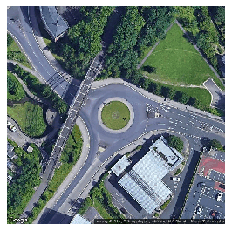

In [21]:
file='../data/test/Roundabout/R2.png'
img = tf.keras.preprocessing.image.load_img(file, target_size=[250, 250])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.efficientnet.preprocess_input(
    x[tf.newaxis,...])


Now we send that processed data to our endpoint.

In [22]:
predictor.predict(x)

b'{\n    "predictions": [[0.0572432205, 0.936643362, 0.00611335412]\n    ]\n}'

As you can see the prediction has sent back a confidence score for each class. The second value in the list corresponds to the class label "Roundabout" which has the highest confidence score

## Inference With Image Output

In [224]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(entry_point='inference.py',
              source_dir='export/code',
              model_data=estimator_tf.model_data,
              framework_version="2.4.1",
              role=role)

In [225]:
model.deploy(instance_type='ml.m5.2xlarge', initial_instance_count=1)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


------!

In [226]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import BytesDeserializer

endpoint_name = model.endpoint_name

nupred=Predictor(endpoint_name=endpoint_name,
                    sagemaker_session=sagemaker_session, 
                    serializer=IdentitySerializer(content_type='application/x-image'),
                    deserializer=BytesDeserializer())

In [227]:
endpoint_name

'tensorflow-inference-2022-08-17-20-10-56-837'

In [228]:
import numpy
import io
from PIL import Image

img = Image.open(file, mode='r')

img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()


In [229]:
output = nupred.predict(img_byte_arr)

In [230]:
opimg = Image.open(io.BytesIO(output))

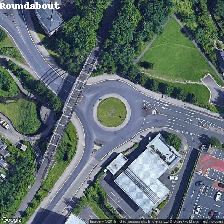

In [231]:
opimg

## Serverless Inference

In [249]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(entry_point='inference.py',
              #endpoint_name='tensorflow-serverless-inference',
              source_dir='export/code',
              model_data=estimator_tf.model_data,
              framework_version="2.4.1",
              role=role)

In [250]:
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig

serverless_config = ServerlessInferenceConfig(
    memory_size_in_mb=6144,
    max_concurrency=1,
)

In [256]:
predictor = model.deploy(
                        endpoint_name="tensorflow-serverless-inference",
                        serverless_inference_config=serverless_config,
                        serializer=IdentitySerializer(content_type='application/x-image'),
                        deserializer=BytesDeserializer())

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

In [259]:
import numpy
import io
from PIL import Image

img = Image.open(file, mode='r')

img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()


In [260]:
output = predictor.predict(img_byte_arr)

In [261]:
opimg = Image.open(io.BytesIO(output))

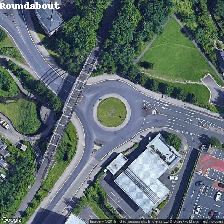

In [262]:
opimg

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
predictor.delete_endpoint()

## Batch Inference

We will start by creating a S3 URI to the model artifacts package generated from the training step

In [232]:
model_data = f"{estimator_tf.output_path}{estimator_tf._current_job_name}/output/model.tar.gz"

First let us make sure we are in the correct starting folder

In [233]:
%cd ~/SageMaker/pssummitwkshp/tensorflow/

[Errno 2] No such file or directory: '/root/SageMaker/pssummitwkshp/tensorflow/'
/root/pssummitwkshp/tensorflow


Now we will create a local export folder so we can store our inference code in a code folder. We can also specify a requirements.txt for any package dependencies  

In [234]:
! mkdir ./export

mkdir: cannot create directory ‘./export’: File exists


Now we copy and unpack the model artifacts file

In [235]:
!aws s3 cp {model_data} ./export/

download: s3://sagemaker-us-east-1-650687152614/tensorflow-pssummit-traffic-class-2022-08-17-13-00-51-969/output/model.tar.gz to export/model.tar.gz


In [236]:
!tar -xvzf ./export/model.tar.gz -C ./export/

tf000000001/
tf000000001/1/
tf000000001/1/saved_model.pb
tf000000001/1/variables/
tf000000001/1/variables/variables.index
tf000000001/1/variables/variables.data-00000-of-00001
tf000000001/1/assets/


In [237]:
%cd export

/root/pssummitwkshp/tensorflow/export


We now delete any old model artifacts folders and move the unpacked model artifacts folder to the 1 folder

In [238]:
! rm -r 1

In [239]:
! mv tf000000001/1 .

In [240]:
! rm -r code/.ipynb_checkpoints/

We now package up the code and 1 folder to create a new model.tar.gz file

In [241]:
! tar -czvf model.tar.gz code 1

code/
code/requirements.txt
code/inference.py
1/
1/variables/
1/variables/variables.data-00000-of-00001
1/variables/variables.index
1/saved_model.pb
1/assets/


We copy the new model.tar.gz to your S3 bucket and setup our Tensorflow Serving Container https://github.com/aws/sagemaker-tensorflow-serving-container

In [242]:
import os
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
sm_role=sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
# See the following document for more on SageMaker Roles:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html
role = sm_role

# Will be using the bucket variable defined at beginning of this notebook

prefix = 'tf_model'
s3_path = 's3://{}/{}'.format(bucket, prefix)

model_data = sagemaker_session.upload_data('model.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))
                                           
tensorflow_serving_model = TensorFlowModel(model_data=model_data,
                                 role=role,
                                 framework_version='2.4.1',
                                 sagemaker_session=sagemaker_session)

We then specify the output folder and run the transformer method to start the batch processing

In [243]:
output_path = f's3://{bucket}/{prefix}/output'
tensorflow_serving_transformer = tensorflow_serving_model.transformer(
                                     instance_count=2,
                                     instance_type='ml.m5.4xlarge',
                                     max_concurrent_transforms=64,
                                     max_payload=1,
                                     output_path=output_path)

input_path = f's3://{bucket}/test'
tensorflow_serving_transformer.transform(input_path, content_type='application/x-image')

.........................INFO:__main__:PYTHON SERVICE: True
INFO:__main__:starting services
INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: 'model'
    base_path: '/opt/ml/model'
    model_platform: 'tensorflow'
    model_version_policy: {
      specific: {
        versions: 1
      }
    }
  }
}
INFO:__main__:tensorflow version info:
2022-08-17 20:26:46.640494: W external/org_tensorflow/tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-08-17 20:26:46.640591: W external/org_tensorflow/tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
TensorFlow ModelServer: 2.4.0-rc4+dev.sha.no_git
TensorFlow Library: 2.4.1
INFO:__main__:tensorflow serving command: tensorflow_model_server --port=10000 --rest_api_port=10001 --mode

The output of this batch job will be in the following S3 URI

In [45]:
output_path

's3://agm-dov-temp/tf_model/output'

We can look at the output file from the batch job. Each file is a prediction that corresponds to the input image file name 

In [ ]:
! aws s3 ls {output_path} --recursive | grep -v ".ipy"

### Attach to a training job that has been left to run 

If your kernel becomes disconnected and your training has already started, you can reattach to the training job.<br>
In the cell below, replace **your-unique-bucket-name** with the name of bucket you created in the data-prep notebook<br>
Then look up the training job name and replace the **your-training-job-name** and then run the cell below. <br>
Once the training job is finished, you can continue the cells after the training cell

In [ ]:
import tensorflow as tf
from sagemaker.tensorflow import TensorFlow
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "your-unique-bucket-name"

training_job_name = 'your-training-job-name'

if 'your-training' not in training_job_name:
    estimator_tf = TensorFlow.attach(training_job_name=training_job_name)